## 1. Loading the NIPS papers
<p>The NIPS conference (Neural Information Processing Systems) is one of the most prestigious yearly events in the machine learning community. At each NIPS conference, a large number of research papers are published. Over 50,000 PDF files were automatically downloaded and processed to obtain a dataset on various machine learning techniques. These NIPS papers are stored in <code>datasets/papers.csv</code>. The CSV file contains information on the different NIPS papers that were published from 1987 until 2017 (30 years!). These papers discuss a wide variety of topics in machine learning, from neural networks to optimization methods and many more.
<img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_158/img/nips_logo.png" alt="The logo of NIPS (Neural Information Processing Systems)"></p>
<p>First, we will explore the CSV file to determine what type of data we can use for the analysis and how it is structured. A research paper typically consists of a title, an abstract and the main text. Other data such as figures and tables were not extracted from the PDF files. Each paper discusses a novel technique or improvement. In this analysis, we will focus on analyzing these papers with natural language processing methods.</p>

In [1]:
# Importing modules
import pandas as pd

# Read datasets/papers.csv into papers
papers = pd.read_csv('datasets/papers.csv')

# Print out the first rows of papers
papers.head(1)

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...


## 2. Preparing the data for analysis
<p>For the analysis of the papers, we are only interested in the text data associated with the paper as well as the year the paper was published in.</p>
<p>We will analyze this text data using natural language processing.  Since the file contains some metadata such as id's and filenames, it is necessary to remove all the columns that do not contain useful text information.</p>

In [2]:
# Remove the columns
papers.drop(['id', 'event_type', 'pdf_name'], axis = 1, inplace = True)
# Print out the first rows of papers
papers.head(1)

,year,title,abstract,paper_text
0,1987,Self-Organization of Associative Database and ...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...


## 3. Plotting how machine learning has evolved over time
<p>In order to understand how the machine learning field has recently exploded in popularity, we will begin by visualizing the number of publications per year. </p>
<p>By looking at the number of published papers per year,  we can understand the extent of the machine learning 'revolution'! Typically, this significant increase in popularity is attributed to the large amounts of compute power, data and improvements in algorithms.</p>

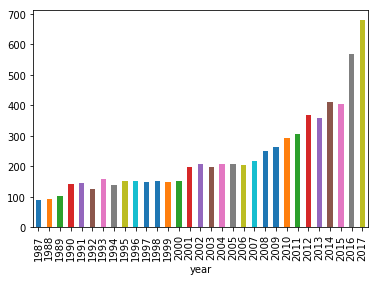

In [3]:
# Group the papers by year
groups = papers.groupby(['year'])

# Determine the size of each group
counts = groups.size()

# Visualise the counts as a bar plot
import matplotlib.pyplot
%matplotlib inline
counts.plot(kind = 'bar')

## 4. Preprocessing the text data
<p>Let's now analyze the titles of the different papers to identify machine learning trends. First, we will perform some simple preprocessing on the titles in order to make them more amenable for analysis. We will use a regular expression to remove any punctuation in the title. Then we will perform lowercasing. We'll then print the titles of the first rows before and after applying the modification.</p>

In [4]:
# Load the regular expression library
import re

# Print the titles of the first rows 
print(papers['title'].head())

# Remove punctuation
papers['title_processed'] = papers['title'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
papers['title_processed'] = papers['title_processed'].str.lower()

# Print the processed titles of the first rows 
papers.head(5)

0    Self-Organization of Associative Database and ...
1    A Mean Field Theory of Layer IV of Visual Cort...
2    Storing Covariance by the Associative Long-Ter...
3    Bayesian Query Construction for Neural Network...
4    Neural Network Ensembles, Cross Validation, an...
Name: title, dtype: object


,year,title,abstract,paper_text,title_processed
0,1987,Self-Organization of Associative Database and ...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,self-organization of associative database and ...
1,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,a mean field theory of layer iv of visual cort...
2,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,storing covariance by the associative long-ter...
3,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...,bayesian query construction for neural network...
4,1994,"Neural Network Ensembles, Cross Validation, an...",Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a...",neural network ensembles cross validation and ...


## 5.  A word cloud to visualize the preprocessed text data
<p>In order to verify whether the preprocessing happened correctly, we can make a word cloud of the titles of the research papers. This will give us a visual representation of the most common words. Visualisation is key to understanding whether we are still on the right track! In addition, it allows us to verify whether we need additional preprocessing before further analyzing the text data.</p>
<p>Python has a massive number of open libraries! Instead of trying to develop a method to create word clouds ourselves, we'll use Andreas Mueller's <a href="http://amueller.github.io/word_cloud/">wordcloud library</a>.</p>

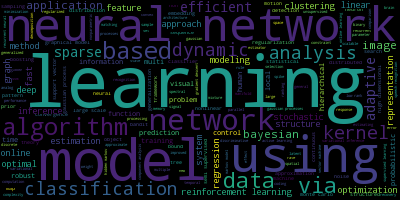

In [5]:
# Import the wordcloud library
import wordcloud 

# Join the different processed titles together.
space = ' '
long_string = space.join(papers['title_processed'])

# Create a WordCloud object
wordcloud = wordcloud.WordCloud()

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

## 6.  Prepare the text for LDA analysis
<p>The main text analysis method that we will use is latent Dirichlet allocation (LDA). LDA is able to perform topic detection on large document sets, determining what the main 'topics' are in a large unlabeled set of texts. A 'topic' is a collection of words that tend to co-occur often. The hypothesis is that LDA might be able to clarify what the different topics in the research titles are. These topics can then be used as a starting point for further analysis.</p>
<p>LDA does not work directly on text data. First, it is necessary to convert the documents into a simple vector representation. This representation will then be used by LDA to determine the topics. Each entry of a 'document vector' will correspond with the number of times a word occurred in the document. In conclusion, we will convert a list of titles into a list of vectors, all with length equal to the vocabulary. For example, <em>'Analyzing machine learning trends with neural networks.'</em> would be transformed into <code>[1, 0, 1, ..., 1, 0]</code>.</p>
<p>We'll then plot the 10 most common words based on the outcome of this operation (the list of document vectors). As a check, these words should also occur in the word cloud.</p>

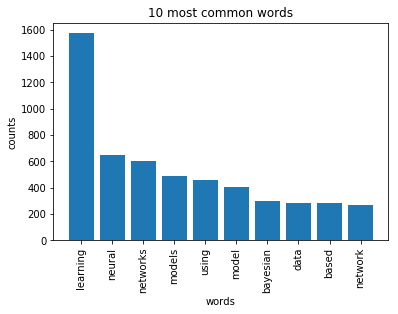

In [6]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 

    plt.bar(x_pos, counts,align='center')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.title('10 most common words')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words = 'english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(papers['title_processed'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

## 7. Analysing trends with LDA
<p>Finally, the research titles will be analyzed using LDA. Note that in order to process a new set of documents (e.g. news articles), a similar set of steps will be required to preprocess the data. The flow that was constructed here can thus easily be exported for a new text dataset.</p>
<p>The only parameter we will tweak is the number of topics in the LDA algorithm. Typically, one would calculate the 'perplexity' metric to determine which number of topics is best and iterate over different amounts of topics until the lowest 'perplexity' is found. For now, let's play around with a different number of topics. From there, we can distinguish what each topic is about ('neural networks', 'reinforcement learning', 'kernel methods', 'gaussian processes', etc.).</p>

In [11]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 10
number_words = 6

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
learning multi markov models kernel selection

Topic #1:
bounds decision approximation bandits function generalization

Topic #2:
learning stochastic linear optimal classification neural

Topic #3:
visual large training detection model scale

Topic #4:
optimization information learning approach variational multiple

Topic #5:
algorithm learning matrix hierarchical convergence machine

Topic #6:
image efficient convex unsupervised analog vlsi

Topic #7:
networks neural deep learning gradient network

Topic #8:
models gaussian estimation regression processes process

Topic #9:
learning analysis sparse data bayesian clustering


# 8. The future of machine learning
<p>Machine learning has become increasingly popular over the past years. The number of NIPS conference papers has risen exponentially, and people are continuously looking for ways on how they can incorporate machine learning into their products and services.</p>
<p>Although this analysis focused on analyzing machine learning trends in research, a lot of these techniques are rapidly being adopted in industry. Following the latest machine learning trends is a critical skill for a data scientist, and it is recommended to continuously keep learning by going through blogs, tutorials, and courses.</p>

In [12]:
# The historical data indicates that:
more_papers_published_in_2018 = True